In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse
# import scipy.sparse.linalg

# Helper functions

In [2]:
def construct_laplacian_kernel_matrix(N, h):
    # Construct the matrix that defines the linear system

    kernel_matrix = -4 * np.eye(N ** 2)
    index_matrix = np.arange(N ** 2).reshape((N, N))

    for i in range(N):
        for j in range(N):
            if i - 1 >= 0:
                kernel_matrix[N * i + j, index_matrix[i - 1, j]] = 1

            if j - 1 >= 0:
                kernel_matrix[N * i + j, index_matrix[i, j - 1]] = 1

            if i + 1 <= N - 1:
                kernel_matrix[N * i + j, index_matrix[i + 1, j]] = 1

            if j + 1 <= N - 1:
                kernel_matrix[N * i + j, index_matrix[i, j + 1]] = 1

    # Divide by h ** 2:
    kernel_matrix = kernel_matrix / h ** 2

    return kernel_matrix

# Simple solver

In [3]:
def simple_solver(w):
    N = w.shape[0] - 2
    nx = N + 2
    ny = N + 2 # = nx

    h = 1 / (N + 1)
    
    # Construct the matrix that defines the linear system
    kernel_matrix = construct_laplacian_kernel_matrix(N, h)
    
    # Cast vorticity to the required form
    w = -w[1:-1, 1:-1].flatten().reshape((N ** 2, 1))
    
    # Solve the sparse linear system
    psi = np.linalg.solve(kernel_matrix, w)
    
    psi = psi.reshape(N, N)

    psi = np.pad(psi, (1, 1), mode="constant")
    
    return psi


# Sparse solver

In [4]:
def sparse_solver(w):
    N = w.shape[0] - 2
    nx = N + 2
    ny = N + 2 # = nx

    h = 1 / (N + 1)
    
    # Construct the sparse matrix
    rows = []
    cols = []
    values = []
    
    for i in range(N):
        for j in range(N):
            rows.append(N * i + j)
            cols.append(N * i + j)
            values.append(-4 / h ** 2)
            
            if i - 1 >= 0:
                rows.append(N * i + j)
                cols.append(N * (i - 1) + j)
                values.append(1 / h ** 2)

            if j - 1 >= 0:
                rows.append(N * i + j)
                cols.append(N * i + (j - 1))
                values.append(1 / h ** 2)

            if i + 1 <= N - 1:
                rows.append(N * i + j)
                cols.append(N * (i + 1) + j)
                values.append(1 / h ** 2)

            if j + 1 <= N - 1:
                rows.append(N * i + j)
                cols.append(N * i + (j + 1))
                values.append(1 / h ** 2)

    # Create the sparse matrix from the above information
    kernel_matrix_sparse = sparse.csr_matrix((values, (rows, cols)), shape=(N ** 2, N ** 2))
    
    # Cast the dense vorticity matrix to sparse
    w = sparse.csr_matrix(-w[1:-1, 1:-1].flatten().reshape((N ** 2, 1)))
    
    # Solve the sparse linear system
    psi = sparse.linalg.spsolve(kernel_matrix_sparse, w)
    
    psi = psi.reshape(N, N)

    psi = np.pad(psi, (1, 1), mode="constant")
    
    return psi


# Gauss-Seidel with SOR

In [5]:
def gauss_seidel_with_sor_solver(w, r=None):
    N = w.shape[0] - 1
    nx = N + 1
    ny = N + 1 # = nx

    h = 1 / N

    # SOR parameter
    if r is None:
        r = 2 / (1 + np.pi / N) # optimal value

    psi = np.zeros((nx, ny)) # initialize the streamfunction

    N_ITERATIONS = 4 * nx
    for iteration in range(1, N_ITERATIONS + 1):
        for i in range(1, nx - 1):
            for j in range(1, ny - 1):
                psi[i, j] = (1 - r) * psi[i, j] + r * (
                    psi[i - 1, j] + psi[i + 1, j] + psi[i, j - 1] + psi[i, j + 1] + w[i, j] * h ** 2
                ) / 4

    return psi

In [6]:
# Initialize grid and the value of the vorticity on it
nx = ny = 21
h = 1 / 20
x_grid, y_grid = np.meshgrid(np.linspace(0, 1, nx), np.linspace(0, 1, ny), indexing="ij")
w = 2 * np.pi ** 2 * np.sin(np.pi * x_grid) * np.sin(np.pi * y_grid) # vorticity

# Solve the system
psi_1 = simple_solver(w)
psi_2 = sparse_solver(w)
psi_3 = gauss_seidel_with_sor_solver(w)

In [7]:
np.allclose(psi_1, psi_2), np.allclose(psi_1, psi_3), np.allclose(psi_2, psi_3)

(True, True, True)

In [8]:
%%time

# Initialize grid and the value of the vorticity on it
nx = ny = 101
h = 1 / 100
x_grid, y_grid = np.meshgrid(np.linspace(0, 1, nx), np.linspace(0, 1, ny), indexing="ij")
w = 2 * np.pi ** 2 * np.sin(np.pi * x_grid) * np.sin(np.pi * y_grid) # vorticity

# Solve the system
psi = sparse_solver(w)

CPU times: user 108 ms, sys: 16.3 ms, total: 124 ms
Wall time: 155 ms


In [9]:
abs_err = 0
for i in range(nx):
    for j in range(ny):
        abs_err = max(abs(psi[i, j] - np.sin(np.pi * i * h) * np.sin(np.pi * j * h)), abs_err)

print(f"abs_err = {abs_err}; psi(0.5, 0.5) = {psi[nx // 2, ny // 2]}")

abs_err = 8.225076215495619e-05; psi(0.5, 0.5) = 1.000082250762155


In [10]:
abs_err = np.max(np.abs(psi - np.sin(np.pi * x_grid) * np.sin(np.pi * y_grid)))
abs_err

8.225076215495619e-05

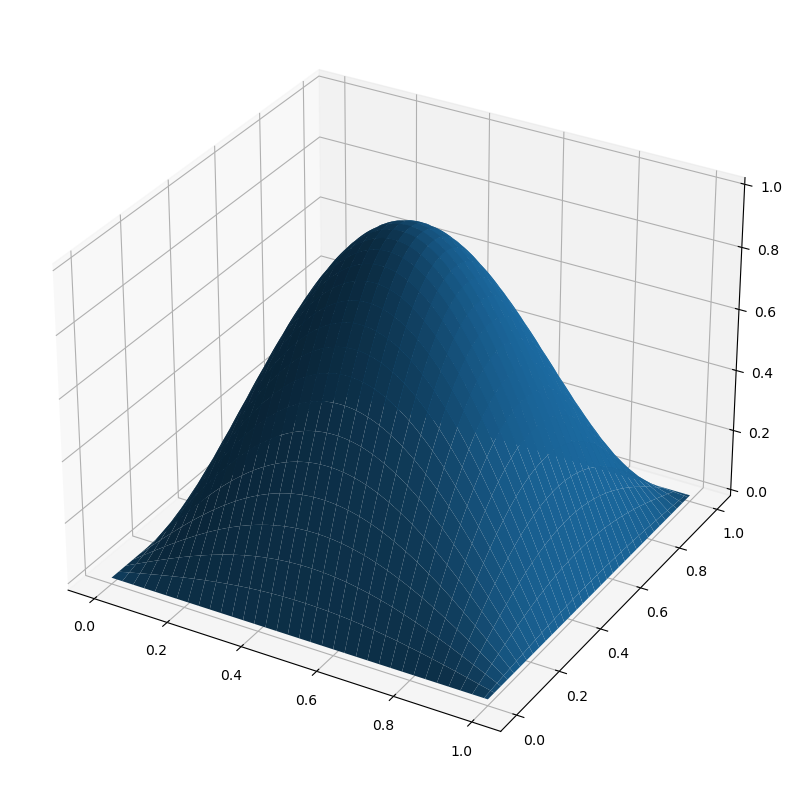

In [11]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')

# Plot the surface
ax.plot_surface(x_grid, y_grid, psi)

plt.show()

In [12]:
xyz = np.stack([
    np.round(x_grid, 2).flatten(), y_grid.flatten(), psi.flatten()
]).T
xyz.shape

(10201, 3)

In [13]:
np.allclose(psi, psi.T)

True

In [14]:
# import pandas as pd

# pd.DataFrame(xyz).to_csv("data/poisson/poisson.csv", index=False, header=False)

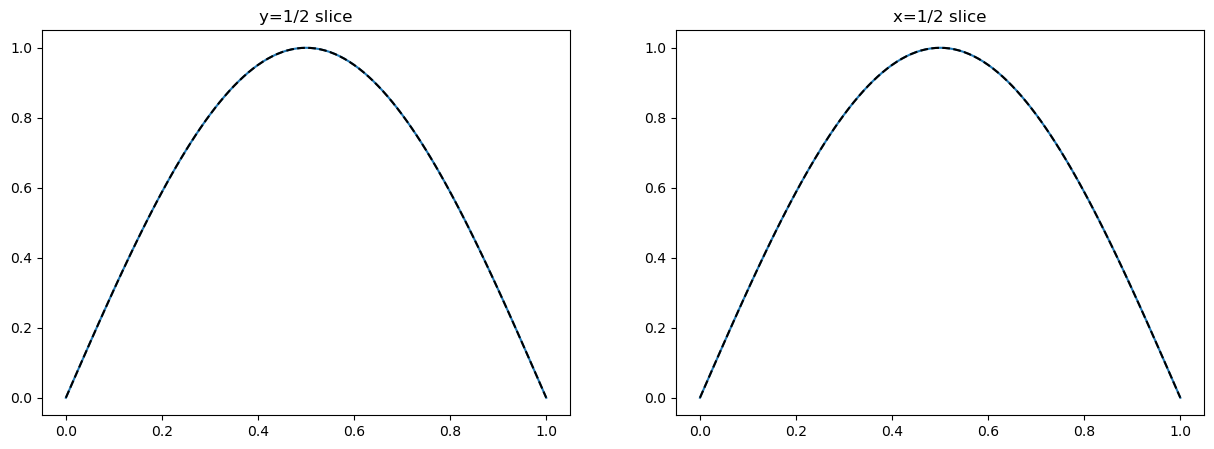

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot the surface
ax1.plot(x_grid[:, 0], psi[:, ny // 2])
ax1.plot(x_grid[:, 0], np.sin(np.pi*x_grid[:, 0]), "--", color="black")
ax1.set_title("y=1/2 slice")

ax2.plot(y_grid[0, :], psi[nx // 2, :])
ax2.plot(y_grid[0, :], np.sin(np.pi*y_grid[0, :]), "--", color="black")
ax2.set_title("x=1/2 slice")

plt.show()

In [16]:
# xy = np.vstack([x_grid[0, :], psi[:, ny // 2]]).T
# print(xy.shape)

# np.savetxt('data/poisson/poisson_y_slice.txt', xy, delimiter=' ', fmt=['%.2f', '%.18f'])

In [17]:
# xy = np.vstack([y_grid[:, 0], psi[nx // 2, :]]).T
# print(xy.shape)

# np.savetxt('data/poisson/poisson_x_slice.txt', xy, delimiter=' ', fmt=['%.2f', '%.18f'])

In [18]:
max_location = np.unravel_index(psi.argmax(), psi.shape)
max_location, psi[max_location]

((50, 50), 1.000082250762155)

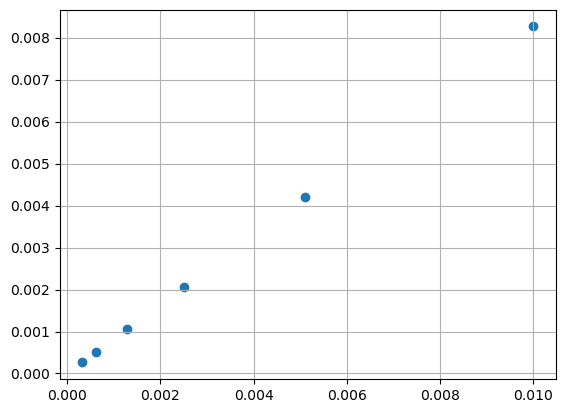

In [19]:
# error dependence on h

errors = []
N_values = np.array([10, 14, 20, 28, 40, 56])
for N_value in N_values:
    nx = ny = N_value + 1
    h = 1 / N_value
    x_grid, y_grid = np.meshgrid(np.linspace(0, 1, nx), np.linspace(0, 1, ny), indexing="ij")
    w = 2 * np.pi ** 2 * np.sin(np.pi * x_grid) * np.sin(np.pi * y_grid) # vorticity
    
    psi = sparse_solver(w)                
    
    abs_err = 0
    for i in range(nx):
        for j in range(ny):
            abs_err = max(abs(psi[i, j] - np.sin(np.pi * i * h) * np.sin(np.pi * j * h)), abs_err)
    errors.append(abs_err)
    
plt.scatter(1 / N_values ** 2, errors)
plt.grid()
# plt.legend()
plt.show()

In [20]:
(slope, intercept), fit_errors = np.polyfit(1 / N_values ** 2, errors, deg=1, cov=True)
print(f"Estimated slope is: {slope} +- {fit_errors[0, 0]}")

Estimated slope is: 0.8266454126956301 +- 2.784193344110136e-07


In [21]:
# xy = np.vstack([1 / N_values ** 2, errors]).T
# print(xy.shape)

# # np.savetxt('data/poisson/poisson_x_slice.txt', xy, delimiter=' ', fmt=['%.2f', '%.18f'])
# np.savetxt('data/poisson/errors.txt', xy, delimiter=' ', fmt='%.18f')

In [22]:
# Check the case w = 0 implies psi = 0

# Initialize grid and the value of the vorticity on it
nx = ny = 21
h = 1 / 20
x_grid, y_grid = np.meshgrid(np.linspace(0, 1, nx), np.linspace(0, 1, ny), indexing="ij")
w = np.zeros((nx, ny)) # vorticity

# Solve the system
psi_1 = simple_solver(w)
psi_2 = sparse_solver(w)
psi_3 = gauss_seidel_with_sor_solver(w)

np.any(psi_1), np.any(psi_2), np.any(psi_3)

(False, False, False)